<a href="https://colab.research.google.com/github/BuddGao/DL-Competition/blob/main/Final_covid19_predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#COVID-19 Prediction

In [ ]:
## mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
## if you haven't unzipped training data
#!unzip "drive/MyDrive/DL_Project/Train.zip" -d  "drive/MyDrive/DL_Project/"

## if you haven't unzipped val data
#!unzip "drive/MyDrive/DL_Project/Val Blind.zip" -d  "drive/MyDrive/DL_Project/"

## Custom Dataset Class

In [ ]:
## preprocess data
## create custom data class

from sklearn.model_selection import KFold
import os
import torch
import pandas as pd
from skimage import io, transform

#from monai.transforms import Compose, LoadImage, AddChannel, ScaleIntensity,RandRotate, ToTensor, RandFlip, RandZoom, Resize, RandGaussianNoise
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, models, datasets
import cv2
from PIL import Image
import glob

class CovidDataset(Dataset):
    """Covid CT dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.label_data = pd.read_csv(csv_file)
        self.root_dir = root_dir
        ## you can apply custom transformation on the image for data augmentation
        self.transform = transform

    def __len__(self):
        return len(self.label_data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir, self.label_data.iloc[idx, 0])
        image = io.imread(img_name)
        image = cv2.cvtColor(image, cv2.COLOR_BGRA2BGR)
        
 
        p = self.label_data.iloc[idx, 1]

        subject_num = self.label_data.iloc[idx, 2]
        

        # should be only applied on image, not percentage or subject #
        if self.transform:
            image = self.transform(image)
        sample = {'image': image, 'percentage': p, 'subject': subject_num, 'img_name':img_name}
        return sample

In [ ]:
class CovidTestDataset(Dataset):
    """Covid CT TEST dataset."""

    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.image_list = []
        for filename in glob.glob(self.root_dir+"/*.png"): #assuming png
          self.image_list.append(filename)

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = self.image_list[idx]
        image = io.imread(img_name)
        image = cv2.cvtColor(image, cv2.COLOR_BGRA2BGR)
        image = torchvision.transforms.functional.to_tensor(image)

        # should be only applied on image, not percentage or subject #
        if self.transform:
            image = self.transform(image)
    
        sample = {'image': image, 'img_name':img_name}
        return sample

In [ ]:
import torchvision
covid_dataset_train_val = CovidDataset(csv_file='drive/MyDrive/DL_Project/Train.csv',
                                    root_dir='drive/MyDrive/DL_Project/Train'
                                    ,transform = transforms.Compose([
                                                transforms.ToPILImage(),                     
                                                transforms.Resize((224, 224)),
                                                transforms.RandomHorizontalFlip(),
                                                transforms.RandomRotation(15),
                                                
                                                transforms.ToTensor(),
                                                
                                                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) ])
                                    
                                    )

covid_dataset_test = CovidTestDataset(root_dir='drive/MyDrive/DL_Project/Val',
                                      transform = transforms.Compose([
                                                transforms.ToPILImage(),                     
                                                transforms.Resize((224, 224)),

                                                transforms.ToTensor(),
                                                
                                                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) ])
                                    )

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 torch.Size([3, 224, 224]) 0.0 0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1 torch.Size([3, 224, 224]) 0.0 0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2 torch.Size([3, 224, 224]) 0.0 0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3 torch.Size([3, 224, 224]) 0.0 0


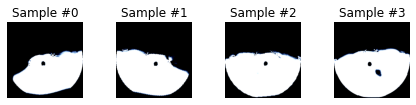

In [ ]:
## plot training example
for i in range(len(covid_dataset_train_val)):
    sample = covid_dataset_train_val[i]
    print(i, sample['image'].shape, sample['percentage'], sample['subject'])
    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    plt.imshow(sample['image'].numpy().transpose(1,2,0))
    if i == 3:
        plt.show()
        break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 torch.Size([3, 224, 224]) drive/MyDrive/DL_Project/Val/Image_0304.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1 torch.Size([3, 224, 224]) drive/MyDrive/DL_Project/Val/Image_0301.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2 torch.Size([3, 224, 224]) drive/MyDrive/DL_Project/Val/Image_0302.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3 torch.Size([3, 224, 224]) drive/MyDrive/DL_Project/Val/Image_0303.png


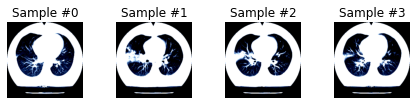

In [ ]:
## plot test examples
for i in range(len(covid_dataset_test)):
    sample = covid_dataset_test[i]
    print(i, sample['image'].shape, sample['img_name'])
    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    plt.imshow(sample['image'].numpy().transpose(1,2,0))
    if i == 3:
        plt.show()
        break

##Split given train set to train & val set

### Apply CV

In [ ]:
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.model_selection import KFold

# generate the index of subjects for k-fold cross validation
def generate_index(dat,k):
    
    Y = list(range(0,dat[-1]['subject']+1))
    kf = KFold(n_splits=k, shuffle=True)

    n = len(Y)
    index = {'train_index':[],
             'val_index':[]}

    for train_index, val_index in kf.split(np.zeros(n), Y):
        index['train_index'].append(train_index)
        index['val_index'].append(val_index)
        
    
    return pd.DataFrame(index['train_index']).T,pd.DataFrame(index['val_index']).T

In [ ]:
# get links form subjects to images
df = pd.read_csv('drive/MyDrive/DL_Project/Train.csv')
subtoimage = []
le = []
for sub in range(0,covid_dataset_train_val[-1]['subject']+1):
  subtoimage.append(df[df['0'] == sub].index.tolist())
  le.append(len(df[df['0'] == sub].index.tolist()))

In [ ]:
# get images' index form subjects' index
def get_image_index(subindex,subtoimage):
    imageindex = []
    for sub in range(0,len(subindex)):
        imageindex.extend(subtoimage[subindex[sub]])
    return imageindex

In [ ]:
# from typing import NewType
def cv_train(pars, k=4, dir='drive/MyDrive/DL_Project/CV/',n_epochs=20):
  train_index,val_index = generate_index(covid_dataset_train_val,k)
  model_cv = []
  valid_cvloss = []
  valid_cvloss_trend = []
  for split_i in range(0,k):
    print('CV - Fold ', split_i)
    fold_dir = dir + str(split_i) + '/'

    if not os.path.isdir(fold_dir):
      os.makedirs(fold_dir)
      print("created folder : ", fold_dir)
    else:
      print(fold_dir, "folder already exists.")

    model, cri, lr = pars
    freeze_stat = True
    model_CNN = model(pretrained=True,freeze=freeze_stat).to(device)
    criterion = cri
    model_CNN_grad_paramaters = filter(lambda p: p.requires_grad, model_CNN.parameters())
    optimizer = optim.Adam(model_CNN_grad_paramaters, lr=lr)

    ## split given train set to train & val set by subjects
    train_imageindex = get_image_index(train_index.iloc[:,split_i],subtoimage)
    val_imageindex = get_image_index(val_index.iloc[:,split_i],subtoimage)
    train_dataset = torch.utils.data.Subset(covid_dataset_train_val,train_imageindex)
    val_dataset = torch.utils.data.Subset(covid_dataset_train_val,val_imageindex)
    train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=0)
    val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=True, num_workers=0)

    ## training model
    model_conv, valid_loss_min, valid_loss_trend = train_model(model_CNN, criterion, optimizer,train_dataloader,val_dataloader, dir=fold_dir,n_epochs=n_epochs)

    model_cv.append(model_conv)
    valid_cvloss.append(valid_loss_min)
    valid_cvloss_trend.append(valid_loss_trend)
  
  print('----------------------Final CV loss: %.6f -----------------------' % torch.stack(valid_cvloss).cpu().data.mean() )
  
  return model_cv, valid_cvloss, valid_cvloss_trend

## Import pretrained models library

In [ ]:
## use imagenet pretrained model
## let's start with resnet34
!pip install pretrainedmodels

     |████████████████████████████████| 58 kB 3.2 MB/s 
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60965 sha256=daa56f98dfefaa0e25a3b0b2e83b3727282baeb9f5319d36fb7be6c26a5c0da5
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built pretrainedmodels


## Use CUDA to speed up training

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## Create CNN Model

In [ ]:
import pretrainedmodels
#For model building
import torch
from torch import nn, optim
import torchvision
from torch.nn import functional as F

class CNN3(nn.Module):
    def __init__(self, pretrained=True,freeze=True):
        super(CNN3, self).__init__()
        if pretrained is True:
            self.model = pretrainedmodels.__dict__["resnet50"](pretrained="imagenet")
        else:
            self.model = pretrainedmodels.__dict__["resnet50"](pretrained=None)
        if freeze is True:
            for param in self.model.parameters():
                param.requires_grad = False
        self.conv1 = nn.Conv2d(2048, 512, (2,2), stride=1, padding =0)
        self.conv2 = nn.Conv2d(512, 32, (2,2), stride=1, padding =0)
        self.dropout = nn.Dropout(p=0.5)
        self.conv3 = nn.Conv2d(32, 8, (2,2), stride=1, padding =0)
        self.fc1 = nn.Linear(128, 16)
        self.fc2 = nn.Linear(16, 8)
        self.fc3 = nn.Linear(8, 1)
        
    def forward(self, x):
        bs, _, _, _ = x.shape
        x = self.model.features(x)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.dropout(x)
        x = self.conv3(F.relu(x))

        label = self.fc1(x.reshape(bs, -1))
        label = self.fc2(label)
        label = self.fc3(label)
        return label

## Training Process

In [ ]:
def train_model(model, criterion, optimizer, train_dataloader, val_dataloader, dir='drive/MyDrive/DL_Project/', n_epochs=20):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf
    model_best = model
    valid_loss_trend = []
    for epoch in range(1, n_epochs+1):
        train_loss = 0.0
        valid_loss = 0.0
        # train the model #
        model.train()
        for batch_idx, sample_batched in enumerate(train_dataloader):
            # importing data and moving to GPU
            image, label = sample_batched['image'].to(device), sample_batched['percentage'].to(device)
            # zero the parameter gradients
            optimizer.zero_grad()
            output=model(image).reshape(-1)
            # calculate loss
            loss = criterion((output).type(torch.FloatTensor).to(device), label.type(torch.FloatTensor).to(device))
            # back prop
            loss.backward()
            # grad
            optimizer.step()
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            if batch_idx % 100 == 0:
                print('Epoch %d, Batch %d loss: %.6f' %
                  (epoch, batch_idx + 1, train_loss))
        # validate the model #
        model.eval()
        for batch_idx, sample_batched in enumerate(val_dataloader):
            image, label = sample_batched['image'].to(device), sample_batched['percentage'].to(device)  
            output = model(image).reshape(-1)
            # calculate loss
            loss=criterion((output).type(torch.FloatTensor).to(device), label.type(torch.FloatTensor).to(device))
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))
        
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, train_loss, valid_loss))
        
        valid_loss_trend.append(valid_loss)
        
        ## TODO: save the model if validation loss has decreased
        if valid_loss < valid_loss_min:
            model_best = model
            model_dir = dir+'model.pth'
            torch.save(model.state_dict(), model_dir)
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            valid_loss_min = valid_loss
    # return trained model
    return model_best, valid_loss_min, valid_loss_trend

In [ ]:
# model_conv=train_model(model_CNN, criterion, optimizer)

## Save result on Actual Test Data to csv File

In [ ]:
def save_test_cv(model,dir):
  test_dataloader = DataLoader(covid_dataset_test, batch_size=8, shuffle=True, num_workers=0)
  all_df = pd.DataFrame(columns=[])
  for fold_idx in range(len(model)):
    model_tmp = model[fold_idx]
    col_name = 'fold_'+str(fold_idx)
    df = pd.DataFrame(columns=['image_name',col_name])
    for batch_idx, sample_batched in enumerate(test_dataloader):
        image= sample_batched['image'].to(device)
        img_name= sample_batched['img_name']
        output = model_tmp(image).type(torch.LongTensor).reshape(-1)
        img_name = np.array(img_name).reshape(output.shape[0],1)
        o = output.cpu().data.numpy().reshape(output.shape[0],1)
        a = np.concatenate((img_name,o),axis=1)
        df = df.append(pd.DataFrame(a, columns=df.columns), ignore_index=True)
    #Extracting image name from the image path
    df['image_name']=df['image_name'].str.split("/").str[-1]
    df = df.sort_values('image_name',ignore_index=True)
    all_df[col_name] = df[col_name].astype(float)
  all_df['output'] = all_df.mean(axis=1)
  all_df['image_name'] = df['image_name']
  res = all_df[['image_name','output']]

  file_dir = dir+'predictions.zip'
  print(file_dir)
  comp_opt = dict(method='zip', archive_name='predictions.csv')
  res.to_csv(file_dir, index=False, header=False,compression=comp_opt)
  all_df.to_csv(dir+'cv_predictions.csv', index=False, header=False)
  all_df.head()

## Model Training and Comparing

In [ ]:
# #Setting model and moving to device
# model_CNN = CNN1(True).to(device)

# criterion = nn.L1Loss()
# #optimizer = optim.SGD(model_CNN.parameters(), lr=0.001, momentum=0.9)
# optimizer = optim.Adam(model_CNN.parameters(), lr=0.001)
model_set = [CNN33] # [CNN4,CNN6,CNN7] # CNN1, CNN2, CNN4, CNN22
cri_set = [nn.SmoothL1Loss()] #[nn.L1Loss(),
optim_lr = [0.0001] # 0.0001, 0.0005, 0.001, 0.005

#### CV training

In [ ]:
from itertools import product, chain
import os

comp_model = []
comp_valid_loss = []
comp_valid_trend = []
log = pd.DataFrame(columns=['num','model','criterion','adam_lr','directory'])
root = 'drive/MyDrive/DL_Project/cv/CNN3/'

# for n, (model,cri,lr) in enumerate(product(model_set,cri_set, optim_lr))[1:]:
for n, pars in enumerate(product(model_set,cri_set, optim_lr)):
    # if n ==0:
    #   continue

    # freeze_stat = True
    # model_CNN = model(pretrained=True,freeze=freeze_stat).to(device)
    # criterion = cri
    # model_CNN_grad_paramaters = filter(lambda p: p.requires_grad, model_CNN.parameters())
    # optimizer = optim.Adam(model_CNN_grad_paramaters, lr=lr)

    dir = root+str(n)+'/'
    if not os.path.isdir(dir):
      os.makedirs(dir)
      print("created folder : ", dir)
    else:
      print(dir, "folder already exists.")

    print(n,pars,dir)

    model_conv, valid_loss_min, valid_loss_trend = cv_train(pars,k=4,dir = dir,n_epochs=50)

    # save test result
    save_test_cv(model_conv,dir)
    
    # value_val_loss = valid_loss_min.cpu().data()
    model,cri,lr = pars
    row = pd.Series([n,model,cri,lr,dir],index=log.columns)
    log = log.append(row,ignore_index=True)

    # comp_idx = comp_idx.append(n)
    # comp_idx_model = comp_idx_model.append(model)
    # comp_cri = comp_cri.append(cri)
    # comp_optim = comp_optim.append(optim)

    comp_model.append(model_conv)
    comp_valid_loss.append(valid_loss_min)
    comp_valid_trend.append(valid_loss_trend)

drive/MyDrive/DL_Project/cv/CNN3/0/ folder already exists.
0 (<class '__main__.CNN33'>, SmoothL1Loss(), 0.0001) drive/MyDrive/DL_Project/cv/CNN3/0/
CV - Fold  0
drive/MyDrive/DL_Project/cv/CNN3/0/0/ folder already exists.
Epoch 1, Batch 1 loss: 18.861053
Epoch 1, Batch 101 loss: 16.393227
Epoch 1, Batch 201 loss: 14.237282
Epoch: 1 	Training Loss: 12.938186 	Validation Loss: 6.780434
Validation loss decreased (inf --> 6.780434).  Saving model ...
Epoch 2, Batch 1 loss: 17.884884
Epoch 2, Batch 101 loss: 8.951971
Epoch 2, Batch 201 loss: 8.712848
Epoch: 2 	Training Loss: 8.348583 	Validation Loss: 6.005025
Validation loss decreased (6.780434 --> 6.005025).  Saving model ...
Epoch 3, Batch 1 loss: 5.536206
Epoch 3, Batch 101 loss: 8.004766
Epoch 3, Batch 201 loss: 7.860339
Epoch: 3 	Training Loss: 7.834764 	Validation Loss: 5.781225
Validation loss decreased (6.005025 --> 5.781225).  Saving model ...
Epoch 4, Batch 1 loss: 5.243404
Epoch 4, Batch 101 loss: 7.500581
Epoch 4, Batch 201 los

In [ ]:
val_loss = []
for idx in range(len(comp_valid_loss)):
  mean_val_loss = torch.stack(comp_valid_loss[idx]).cpu().data.mean()
  val_loss.append(mean_val_loss)
log['mean_val_loss'] = torch.stack(val_loss).tolist()
log_path = root+'log.csv'
log.to_csv(root+'log.csv')
log

,num,model,criterion,adam_lr,directory,mean_val_loss
0,0,<class '__main__.CNN3'>,SmoothL1Loss(),0.0001,drive/MyDrive/DL_Project/cv/CNN3/0/,6.60554
